### 패키지 불러오기

In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# early stopping
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

데이터셋 경로 지정

In [2]:
# 데이터셋 경로 지정
train_horse_dir = './dataset/horse-or-human/train/horses'
train_human_dir = './dataset/horse-or-human/train/humans'

학습 데이터 리스트업

In [3]:
# 학습 데이터 리스트업
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

horse_files = [train_horse_dir + '/' + f for f in train_horse_names]
human_files = [train_human_dir + '/' + f for f in train_human_names]

# 학습 데이터의 개수 확인
print('horse:', len(train_horse_names))
print('human:', len(train_human_names))

horse: 4500
human: 4743


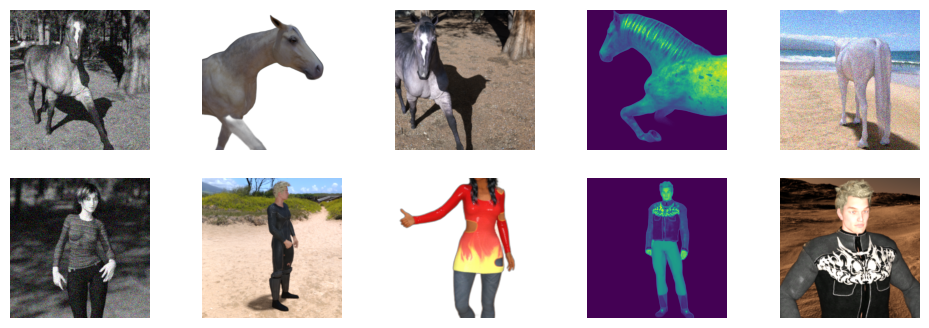

In [4]:
# 데이터 미리보기
fig, axes = plt.subplots(2,5, figsize=(12,4))
ax = np.reshape(axes, -1)

for i, path in enumerate(horse_files[:5] + human_files[:5]):
    img = plt.imread(path)
    ax[i].axis('off')
    ax[i].imshow(img)

plt.show()

### 딥러닝 모델 설계하기

In [5]:
# 모델 설계
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.BatchNormalization(),  # 추가
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),  # 추가
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),  # 추가
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),  # 추가
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),  # 추가
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # 과적합 방지를 위한 Dropout 추가
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-06 09:22:56.834680: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-06 09:22:56.834707: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-06 09:22:56.834725: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-06 09:22:56.834776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-06 09:22:56.834815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 298, 298, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 147, 147, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 33, 33, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,705,057 (6.50 MB)

 Trainable params: 1,704,577 (6.50 MB)

 Non-trainable params: 480 (1.88 KB)

In [6]:
model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [7]:
# 이미지 값을 0~1 사이로 제한
train_datagen = ImageDataGenerator(rescale=1/255.)

# train set
train_generator = train_datagen.flow_from_directory(
  './dataset/horse-or-human/train/',
  target_size=(300, 300),  # 해상도 조절
  batch_size=32,  # 배치 크기
  class_mode='binary'  # 분류 방법
)

# valid set
valid_generator = train_datagen.flow_from_directory(
  './dataset/horse-or-human/validation/',
  target_size=(300, 300),
  batch_size=32,
  class_mode='binary'
)

# EarlyStopping 설정
es = EarlyStopping(
    monitor='val_loss',   # val_loss를 모니터링
    patience=3,           # 개선되지 않은 3번의 epoch 이후 종료
    verbose=1,            # 콘솔에 조기 종료 로그 표시
    restore_best_weights=True  # 가장 성능이 좋은 모델 가중치로 복원
)


checkpoint = ModelCheckpoint(
  filepath='./checkpoint.keras', # 모델의 임시저장 파일을 어디에 만들것인가
  verbose=2, # 로그를 보여줄지
  save_best_only=True, # 가장 best 값만 저장할 것인가
  monitor='val_loss',
  mode='auto'
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-6,
    verbose=1
)

# 클래스 비율에 따라 가중치 계산
class_weights = {0: 3162 / (3000 + 3162),  # Horse에 대한 가중치
                 1: 3000 / (3000 + 3162)}  # Human에 대한 가중치

# steps_per_epoch 설정
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# 모델 학습 시 class_weight 매개변수에 전달
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,  # 올바른 steps_per_epoch 값 설정
    validation_data=valid_generator,
    validation_steps=validation_steps,  # 검증 세트에 대해서도 동일하게 설정
    epochs=15,
    verbose=1,
    callbacks=[checkpoint, es,lr_scheduler],
    class_weight=class_weights  # 클래스 가중치 적용
)

Found 9243 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/15


2024-09-06 09:22:59.326523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.8741 - loss: 0.1523
Epoch 1: val_loss improved from inf to 0.31335, saving model to ./checkpoint.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 266s 892ms/step - accuracy: 0.8743 - loss: 0.1521 - val_accuracy: 0.9062 - val_loss: 0.3134 - learning_rate: 1.0000e-04
Epoch 2/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step - accuracy: 0.9688 - loss: 0.0714 - learning_rate: 1.0000e-04
Epoch 3/15


2024-09-06 09:27:24.912587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 09:27:24.912626: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10015588284098293300
2024-09-06 09:27:24.912637: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5625120471749663124
2024-09-06 09:27:24.912648: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15474306056236840344
2024-09-06 09:27:24.912657: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10956740370683615322
2024-09-06 09:27:24.912665: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13562400711595452716
2024-09-06 09:27:24.912673: I tensorflow/core/framework/local_rende

288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.9822 - loss: 0.0240
Epoch 3: val_loss did not improve from 0.31335
288/288 ━━━━━━━━━━━━━━━━━━━━ 249s 861ms/step - accuracy: 0.9822 - loss: 0.0240 - val_accuracy: 0.8633 - val_loss: 0.6599 - learning_rate: 1.0000e-04
Epoch 4/15
  1/288 ━━━━━━━━━━━━━━━━━━━━ 5:21 1s/step - accuracy: 1.0000 - loss: 0.0032

2024-09-06 09:31:35.597959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 09:31:35.598027: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14048047038146731876
2024-09-06 09:31:35.598278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_61]]
2024-09-06 09:31:35.598324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10065615451486668528
2024-09-06 09:31:35.598396: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16036322612940539562
2024-09-06 09:31:35.598410: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7097960016025790626
2024-09

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.0032 - learning_rate: 1.0000e-04
Epoch 5/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9938 - loss: 0.0121
Epoch 5: val_loss did not improve from 0.31335

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
288/288 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.9938 - loss: 0.0121 - val_accuracy: 0.7617 - val_loss: 2.4574 - learning_rate: 1.0000e-04
Epoch 6/15
  1/288 ━━━━━━━━━━━━━━━━━━━━ 6:20 1s/step - accuracy: 1.0000 - loss: 0.0017

2024-09-06 09:36:33.003633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 09:36:33.003937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_20/_80]]
2024-09-06 09:36:33.004004: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14048047038146731876
2024-09-06 09:36:33.004036: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10065615451486668528
2024-09-06 09:36:33.004050: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16036322612940539562
2024-09-06 09:36:33.004063: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1748084

288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 0.0017 - learning_rate: 2.0000e-05
Epoch 7/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.9969 - loss: 0.0060
Epoch 7: val_loss did not improve from 0.31335
288/288 ━━━━━━━━━━━━━━━━━━━━ 239s 822ms/step - accuracy: 0.9969 - loss: 0.0060 - val_accuracy: 0.8008 - val_loss: 2.0172 - learning_rate: 2.0000e-05
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 1.


모델 평가

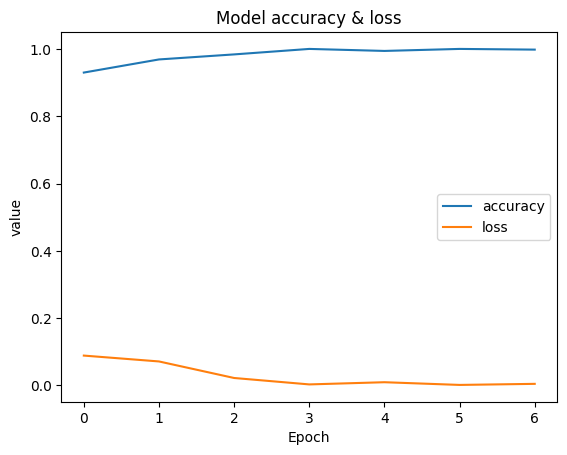

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()

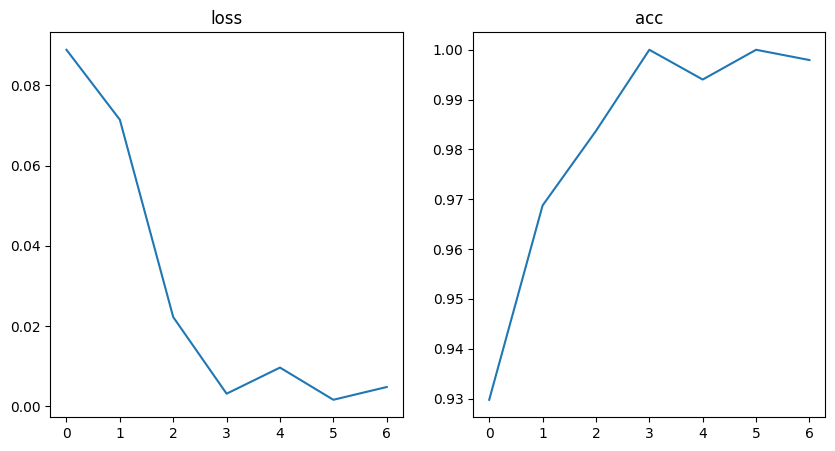

In [9]:
#loss, acc 현황을 그래프로 확인
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("acc")
plt.plot(history.history['accuracy'])
plt.show()

모델 검증

In [10]:
# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9032 - loss: 0.3257
test loss, test acc: [0.31335344910621643, 0.90625]


외부 데이터 테스트

In [14]:
# 이미지 경로 설정
dlist = './dataset/horse-or-human/test/'
predict_list = os.listdir(dlist)

# 이미지 전처리
img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (300, 300)) for i in img]
img = np.array(img)
img = img.astype('float32') / 255.0

# 분류
cutoff = 0.5
predictions = model.predict(img)

# 예측 결과 출력 (파일 이름과 함께)
for idx, prediction in enumerate(predictions):
    file_name = predict_list[idx]
    if prediction >= cutoff:
        print(f"{file_name}: 사람")
    else:
        print(f"{file_name}: 말")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
horse.jpg: 말
horse.webp: 말
horse2.webp: 말
human1.jpg: 말
human2.jpg: 사람
horse3.jpg: 사람
horse1.jpg: 사람


In [12]:
model.save('./model.keras')

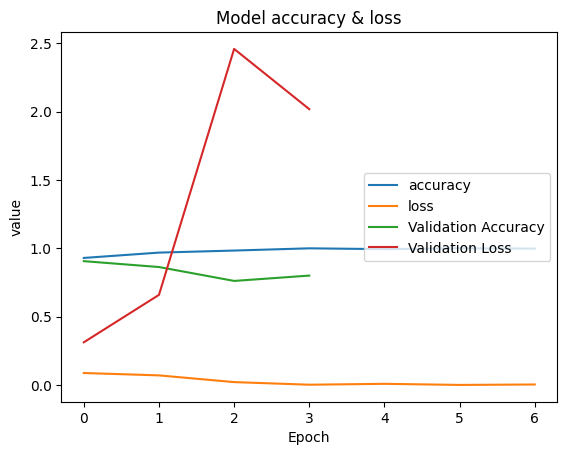

In [13]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])

plt.title("Model accuracy & loss")
plt.xlabel("Epoch")
plt.ylabel("value")
plt.legend(
    ["accuracy", "loss", "Validation Accuracy", "Validation Loss"], loc="center right"
)
plt.show()